# Experimental design and A/B testing of a landing page

## Setting the environment

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
import math
import statsmodels.stats.api as sms
import scipy.stats as st

## Explore the data

In [20]:
# Read from pickled file
base_folder = r'C:\Users\User\OneDrive - Seedergy\MAEN\Code\Projects\Courses\Thinkful2020'
               
coordinate_file = base_folder+r'\ab_edited.csv'
df1 = pd.read_csv(coordinate_file) 

In [32]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290585 entries, 0 to 290584
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       290585 non-null  int64 
 1   timestamp     290585 non-null  object
 2   group         290585 non-null  int32 
 3   landing_page  290585 non-null  int32 
 4   converted     290585 non-null  int64 
 5   date          290585 non-null  object
dtypes: int32(2), int64(2), object(2)
memory usage: 11.1+ MB


In [21]:
df1.head(3)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0


In [22]:
# Convert string lables to binary for ease or work
df1 = df1.copy()
df1['group'] = df1['group'].str.replace('control', '0')
df1['group'] = df1['group'].str.replace('treatment', '1')
df1['landing_page'] = df1['landing_page'].str.replace('old_page', '0')
df1['landing_page'] = df1['landing_page'].str.replace('new_page', '1')
df1['group'] = df1['group'].astype(int)
df1['landing_page'] = df1['landing_page'].astype(int)
df1['date'] = pd.DatetimeIndex(df1['date']).date

In [23]:
df1.head()

,user_id,timestamp,group,landing_page,converted,date
0,851104,2017-01-21 22:11:48.556739,0,0,0,2017-01-21
1,804228,2017-01-12 08:01:45.159739,0,0,0,2017-01-12
2,661590,2017-01-11 16:55:06.154213,1,1,0,2017-01-11
3,853541,2017-01-08 18:28:03.143765,1,1,0,2017-01-08
4,864975,2017-01-21 01:52:26.210827,0,0,1,2017-01-21


In [7]:
df1.describe()

,user_id,group,landing_page,converted
count,290585.000000,290585.000000,290585.000000,290585.000000
mean,788004.825246,0.500064,0.500064,0.119597
std,91224.582639,0.500001,0.500001,0.324490
min,630000.000000,0.000000,0.000000,0.000000
25%,709035.000000,0.000000,0.000000,0.000000
50%,787995.000000,1.000000,1.000000,0.000000
75%,866956.000000,1.000000,1.000000,0.000000
max,945999.000000,1.000000,1.000000,1.000000


In [37]:
# Help functions to gather basic descriptions
def describe(df):
    return pd.concat([df.describe().T,
                      df.mad().rename('mad'),
                      df.skew().rename('skew'),
                      df.kurt().rename('kurt'),
                      df.nunique().rename('unique')
                     ], axis=1).T

describe(df1)

,user_id,group,landing_page,converted,timestamp,date
count,290585.000000,290585.000000,290585.000000,290585.000000,NaN,NaN
mean,788004.825246,0.500064,0.500064,0.119597,NaN,NaN
std,91224.582639,0.500001,0.500001,0.324490,NaN,NaN
min,630000.000000,0.000000,0.000000,0.000000,NaN,NaN
25%,709035.000000,0.000000,0.000000,0.000000,NaN,NaN
50%,787995.000000,1.000000,1.000000,0.000000,NaN,NaN
75%,866956.000000,1.000000,1.000000,0.000000,NaN,NaN
max,945999.000000,1.000000,1.000000,1.000000,NaN,NaN
mad,79008.282245,0.500000,0.500000,0.210587,NaN,NaN
skew,0.000433,-0.000255,-0.000255,2.344640,NaN,NaN


## Analysis of different samples

In [26]:
# How large is each group?
print('group sample size:', len(df1[df1.group == 1]))
print('control sample size:', len(df1[df1.group == 0]))
print('group proportion:', round(df1.group.mean()*100,2),"%")
print()

# What is the signup rate of group and control?
print('group signup rate:', round(df1[df1.group == 1].converted.mean()*100,2),"%")
print('control signup rate:', round(df1[df1.group == 0].converted.mean()*100,2),"%")

# Is the experiment already significant?
stats.ttest_ind(
    df1[df1.group == 1].converted,
    df1[df1.group == 0].converted)

group sample size: 145311
control sample size: 145274
group proportion: 50.01 %

group signup rate: 11.88 %
control signup rate: 12.04 %


Ttest_indResult(statistic=-1.3116069027036805, pvalue=0.18965383906859376)

### The sample sizes are large engouh however the t-test is not significant

### We can double check the required sample size given 5% practical significance criteria

In [33]:
# Check what sample size is required
baseline_rate = conversions_control / total_users_control
practical_significance = 0.05 #user defined
confidence_level = 0.05 #user defined, for a 95% confidence interval
sensitivity = 0.8 #user defined

effect_size = sms.proportion_effectsize(baseline_rate, baseline_rate + practical_significance)
sample_size = sms.NormalIndPower().solve_power(effect_size = effect_size, power = sensitivity, 
                                               alpha = confidence_level, ratio=1)
print('Baseline Rate for conrol group: ', round(baseline_rate*100, 2),"%" " and Practical Sginifiance: ", round(practical_significance*100,3),"%")
print('Confidence Level: ', round(confidence_level*100, 2),"%" " and Sensitivity: ", round(sensitivity*100,3),"%")

print("Required sample size: ", round(sample_size), " per group")

Baseline Rate for conrol group:  12.04 % and Practical Sginifiance:  5.0 %
Confidence Level:  5.0 % and Sensitivity:  80.0 %
Required sample size:  775  per group


## Analysis of converted samples

In [25]:
conversions_control = df1[df1['group'] ==0]['converted'].sum()
total_users_control= df1[df1['group'] ==0]['converted'].count()

conversions_treatment = df1[df1['group'] ==1]['converted'].sum()
total_users_treatment= df1[df1['group'] ==1]['converted'].count()
print("Split of control users vs treatment users: ", 
          round(total_users_control / df1["converted"].count() * 100, 2), "% ",
          round(total_users_treatment / df1["converted"].count() * 100, 2), "%")


#count number of receiver who converted in each group
print("Number of control users who converted: ", conversions_control)
print("Percentage of control users who converted: ", round((conversions_control / total_users_control) * 100, 2), "%")

print("Number of treatment users who converted: ", conversions_treatment)
print("Percentage of treatment users who converted: ", round((conversions_treatment/ total_users_treatment) * 100, 2), "%")

Split of control users vs treatment users:  49.99 %  50.01 %
Number of control users who converted:  17489
Percentage of control users who converted:  12.04 %
Number of treatment users who converted:  17264
Percentage of treatment users who converted:  11.88 %


### Visualize conversion rate for control and treatment group

In [27]:
df1.head(3)

,user_id,timestamp,group,landing_page,converted,date
0,851104,2017-01-21 22:11:48.556739,0,0,0,2017-01-21
1,804228,2017-01-12 08:01:45.159739,0,0,0,2017-01-12
2,661590,2017-01-11 16:55:06.154213,1,1,0,2017-01-11


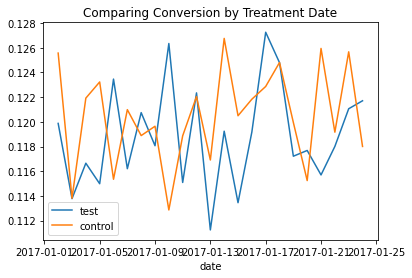

In [38]:

fig = df1[df1.group==1][
    ['date', 'converted']].groupby('date').mean().plot()
df1[df1.group==0][
    ['date', 'converted']].groupby('date').mean().plot(ax=fig)
plt.legend(['test','control'])
plt.title('Comparing Conversion by Treatment Date')
plt.show()

In [36]:
# Generate a test statistic comparing test and control on treatment date
print('T-Test Results by Date')

for day in df1.date.unique():
    dated_data = df1[df1.date == day]
    print(stats.ttest_ind(dated_data[dated_data.group == 1].converted,
                          dated_data[dated_data.group == 0].converted))

T-Test Results by Date
Ttest_indResult(statistic=-1.8123288054674913, pvalue=0.06995793389888251)
Ttest_indResult(statistic=0.05182821974845549, pvalue=0.9586663564605943)
Ttest_indResult(statistic=-0.6795024407954999, pvalue=0.49683133482307695)
Ttest_indResult(statistic=0.33111903181744556, pvalue=0.7405597598504309)
Ttest_indResult(statistic=2.3999515991310387, pvalue=0.01641085244784032)
Ttest_indResult(statistic=-0.4836129647924235, pvalue=0.628668638020595)
Ttest_indResult(statistic=0.7611804663738991, pvalue=0.446562930057432)
Ttest_indResult(statistic=-0.9315635899845935, pvalue=0.3515792521983202)
Ttest_indResult(statistic=-1.261388402374626, pvalue=0.20719113309271808)
Ttest_indResult(statistic=-0.0026642818202597274, pvalue=0.9978742538059032)
Ttest_indResult(statistic=-0.28071255594768935, pvalue=0.7789352633524722)
Ttest_indResult(statistic=-0.2056136446252576, pvalue=0.837095874040602)
Ttest_indResult(statistic=0.4909032980527966, pvalue=0.6235093367111435)
Ttest_indResul

## We do not see any significant difference in control and treatment groups and the same is visible throughout the rollout.

## Just a reminder what p-values mean

##### P-values can indicate how incompatible the data is with a specified statistical model
##### P-values do not measure the probability that the studied hypothesis is true, or the probability that the data was produced by random chance alone
##### Scientific conclusions and business or policy decisions should not be based only on whether a p-value passes a specific threshold
##### Proper inference requires full reporting and transparency
##### A p-value, or statistical significance, does not measure the size of an effect or the importance of a result
##### By itself, a p-value does not provide a good measure of evidence regarding a model or hypothesis